# 12th Question

### What is the average number of games per set in men's matches compared to women's matches?

Installing needed packages

In [1]:
%pip install numpy pandas seaborn pyarrow

Note: you may need to restart the kernel to use updated packages.


Importing needed packages

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import os

# Reading .parquet data
According to question and ERD in /data/ERD folder as Tennis Schema.pdf , We are analyzing and Reading data of matchs
It might take few seconds to read data

In [3]:
days_to_query = os.listdir("../data/raw/tennis_data")
files_to_load = []

for day in days_to_query:
    files_to_load.extend(
        glob(
            f"../data/raw/tennis_data/{day}/data/raw/raw_tennis_power*/power*.parquet"
        )
    )

tennis_statistics_data_frame = pd.concat(
    [
        pd.read_parquet(
            file,
            columns=[
                "match_id",
                "set_num",
                "game_num"
            ],
        )
        for file in files_to_load
    ],
    ignore_index=True,
)

Reading data of home matches required information :

In [5]:
days_to_query_home = os.listdir("../data/raw/tennis_data")
files_to_load_home = []

for day in days_to_query_home:
    files_to_load_home.extend(
        glob(f"../data/raw/tennis_data/{day}/data/raw/raw_match*/home_team_1*.parquet")
    )

home_statistics_data_frame = pd.concat(
    [
        pd.read_parquet(
            file,
            columns=["match_id", "name", "gender"],
        )
        for file in files_to_load_home
    ],
    ignore_index=True,
)

Reading data of away matches required information :

In [6]:
days_to_query_away = os.listdir("../data/raw/tennis_data")
files_to_load_away = []

for day in days_to_query_away:
    files_to_load_away.extend(
        glob(f"../data/raw/tennis_data/{day}/data/raw/raw_match*/away_team_1*.parquet")
    )

away_statistics_data_frame = pd.concat(
    [
        pd.read_parquet(
            file,
            columns=["match_id", "name", "gender"],
        )
        for file in files_to_load_away
    ],
    ignore_index=True,
)

In [ ]:
summary = tennis_statistics_data_frame.groupby(['match_id', 'set_num', 'game_num']).agg({
    'point_winner': 'count',        # total points in game
    'server': lambda x: x.mode()[0],  # most common server
    # add more columns as needed
}).reset_index().rename(columns={'point_winner': 'num_points'})


,match_id,set_num,game_num
0,11998445,1,1
1,11998445,1,2
2,11998445,1,3
3,11998445,1,4
4,11998445,1,5
...,...,...,...
469672,12213803,2,3
469673,12213803,2,4
469674,12213803,2,5
469675,12213803,2,6


In [8]:
away_statistics_data_frame

,match_id,name,gender
0,11998445,Auger-Aliassime F.,M
1,11998446,Cobolli F.,M
2,11998447,Martínez P.,M
3,11998448,Muller A.,M
4,11998449,Mayot H.,M
...,...,...,...
24198,12212216,Doria L.,M
24199,12213156,Soriano Barrera A.,M
24200,12213412,Taberner C.,M
24201,12213458,Simonsson F.,M


In [9]:
home_statistics_data_frame

,match_id,name,gender
0,11998445,Cazaux A.,M
1,11998446,Lestienne C.,M
2,11998447,Ćorić B.,M
3,11998448,Mmoh M.,M
4,11998449,Paire B.,M
...,...,...,...
25605,12213458,Gorokhov M.,M
25606,12213459,Zhu M.,M
25607,12213460,Ojakaar O.,M
25608,12213482,Baldovinetti G.,M


Step 1: Merge home and away gender data into one match-level gender tag

In [ ]:
home_gender = home_statistics_data_frame[['match_id', 'gender']].rename(columns={'gender': 'home_gender'})
away_gender = away_statistics_data_frame[['match_id', 'gender']].rename(columns={'gender': 'away_gender'})

Merge into match_id -> gender frame

In [11]:
match_gender = pd.merge(home_gender, away_gender, on='match_id')

Sanity check – drop mismatches

In [12]:
match_gender = match_gender[match_gender['home_gender'] == match_gender['away_gender']]
match_gender['gender'] = match_gender['home_gender']

Step 2: Merge gender into tennis_statistics_data_frame

In [13]:
stats_with_gender = pd.merge(tennis_statistics_data_frame, match_gender[['match_id', 'gender']], on='match_id', how='inner')

Step 3: Count number of games per set per match

In [14]:
game_counts = stats_with_gender.groupby(['match_id', 'set_num'])['game_num'].nunique().reset_index()
game_counts = pd.merge(game_counts, match_gender[['match_id', 'gender']], on='match_id')

Step 4: Average number of games per set by gender

In [15]:
avg_games = game_counts.groupby('gender')['game_num'].mean().reset_index()
avg_games.columns = ['Gender', 'Avg_Games_Per_Set']

In [18]:
avg_games.head()

,Gender,Avg_Games_Per_Set
0,F,9.036082
1,M,9.412263


# Data Visualization

C:\Users\Shahab\AppData\Local\Temp\ipykernel_11848\1318357265.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_games, x='Gender', y='Avg_Games_Per_Set', palette='pastel')


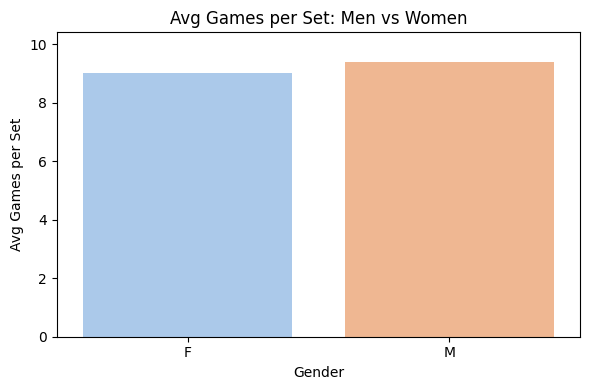

In [26]:
plt.figure(figsize=(6, 4))
sns.barplot(data=avg_games, x='Gender', y='Avg_Games_Per_Set', palette='pastel')
plt.title('Avg Games per Set: Men vs Women')
plt.xlabel('Gender')
plt.ylabel('Avg Games per Set')
plt.ylim(0, avg_games['Avg_Games_Per_Set'].max() + 1)
plt.tight_layout()
plt.show()